In [1]:
import pandas as pd
import numpy as np
from functions_NLM import estimate_nested_logit

In [2]:
from functions_IB import information_bottleneck
from functions_geom_DIB import geom_DIB, DIB_curve
import matplotlib.pyplot as plt


In [3]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data[data['P'] == 0] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [94]:
# Load data
subdata = pd.read_csv('./data/telephone.dat', sep='\t')
subdata = subdata[['cost1', 'cost2', 'cost3', 'cost4', 'cost5', 'avail1', 'avail2', 'avail3', 'avail4', 'avail5', 'choice']]

subdata['logcost1'] = np.log(subdata['cost1'])
subdata['logcost2'] = np.log(subdata['cost2'])
subdata['logcost3'] = np.log(subdata['cost3'])
subdata['logcost4'] = np.log(subdata['cost4'])
subdata['logcost5'] = np.log(subdata['cost5'])

subdata = subdata.iloc[:100]

In [95]:
# Estimate parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]
result_sub, se_sub, t_stat_sub, p_value_sub, aic, bic = estimate_nested_logit(subdata, beta, beta_names, log_likelihood_telephone)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic   p-value
0            ASC_1 -0.372546              0.315989    -1.178983  0.241413
1            ASC_3  2.204279              0.591995     3.723472  0.000337
2            ASC_4  2.049948              1.052588     1.947531  0.054487
3            ASC_5  2.682473              0.792574     3.384510  0.001046
4        BETA_COST -2.762599              0.732993    -3.768931  0.000288
5  lambda_measured  0.839533              0.431222     1.946868  0.054568
6      lambda_flat  1.008942              0.440742     2.289187  0.024331
AIC: 212.34807368365216
BIC: 230.5842649855688


In [96]:
data_logcost = subdata[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Calculate the sum of the log costs for each row
data_logcost['sum_logcost'] = data_logcost[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']].sum(axis=1)

# Compute the empirical distribution
empirical_distribution = data_logcost['sum_logcost'].value_counts(normalize=True)

# Add a column "probability" to the DataFrame
data_logcost['probability'] = data_logcost['sum_logcost'].map(empirical_distribution)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_15750/1472037040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['sum_logcost'] = data_logcost[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']].sum(axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_15750/1472037040.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['probability'] = data_logcost['sum_logcost'].map(empirical_distribution)


In [97]:
p_x_sub = data_logcost['probability'].values
p_y_given_x_sub = subdata[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy_sub = p_x_sub[:, np.newaxis] * p_y_given_x_sub

# Normalize p_xy 
p_xy_sub /= p_xy_sub.sum()

# Define epsilon value
epsilon = 1e-100

# Add epsilon to elements equal to 0
p_xy_sub[p_xy_sub == 0] += epsilon

Iteration: 0 out of 10
Iteration: 1 out of 10
Iteration: 2 out of 10
Iteration: 3 out of 10
Iteration: 4 out of 10
Iteration: 5 out of 10
Iteration: 6 out of 10
Iteration: 7 out of 10
Iteration: 8 out of 10
Iteration: 9 out of 10
Iteration: 0 out of 10
Iteration: 1 out of 10
Iteration: 2 out of 10
Iteration: 3 out of 10
Iteration: 4 out of 10
Iteration: 5 out of 10
Iteration: 6 out of 10
Iteration: 7 out of 10
Iteration: 8 out of 10
Iteration: 9 out of 10
Iteration: 0 out of 10
Iteration: 1 out of 10
Iteration: 2 out of 10
Iteration: 3 out of 10
Iteration: 4 out of 10
Iteration: 5 out of 10
Iteration: 6 out of 10
Iteration: 7 out of 10
Iteration: 8 out of 10
Iteration: 9 out of 10
Iteration: 0 out of 10
Iteration: 1 out of 10
Iteration: 2 out of 10
Iteration: 3 out of 10
Iteration: 4 out of 10
Iteration: 5 out of 10
Iteration: 6 out of 10
Iteration: 7 out of 10
Iteration: 8 out of 10
Iteration: 9 out of 10
Iteration: 0 out of 10
Iteration: 1 out of 10
Iteration: 2 out of 10
Iteration: 

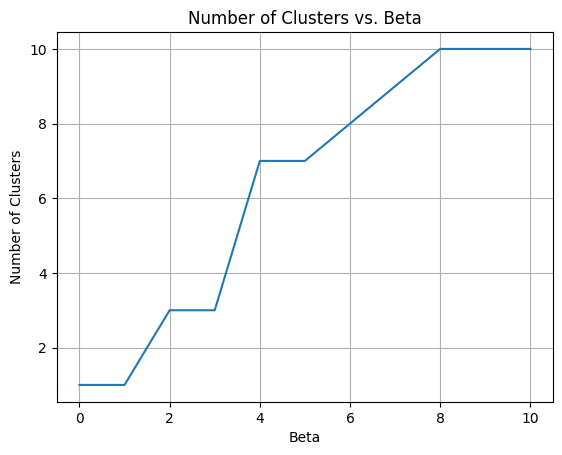

In [98]:
betas = np.linspace(0, 10, 11)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB(p_xy_sub, max_iter=10, beta=beta)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [110]:
q_t_given_x_sub, q_t_sub, q_y_given_t_sub = geom_DIB(p_xy_sub, beta=4, max_iter=100)

Iteration: 0 out of 100
Iteration: 1 out of 100
Iteration: 2 out of 100
Iteration: 3 out of 100
Iteration: 4 out of 100
Iteration: 5 out of 100
Iteration: 6 out of 100
Iteration: 7 out of 100
Iteration: 8 out of 100
Iteration: 9 out of 100
Iteration: 10 out of 100
Iteration: 11 out of 100
Iteration: 12 out of 100
Iteration: 13 out of 100
Iteration: 14 out of 100
Iteration: 15 out of 100
Iteration: 16 out of 100
Iteration: 17 out of 100
Iteration: 18 out of 100
Iteration: 19 out of 100
Iteration: 20 out of 100
Iteration: 21 out of 100
Iteration: 22 out of 100
Iteration: 23 out of 100
Iteration: 24 out of 100
Iteration: 25 out of 100
Iteration: 26 out of 100
Iteration: 27 out of 100
Iteration: 28 out of 100
Iteration: 29 out of 100
Iteration: 30 out of 100
Iteration: 31 out of 100
Iteration: 32 out of 100
Iteration: 33 out of 100
Iteration: 34 out of 100
Iteration: 35 out of 100
Iteration: 36 out of 100
Iteration: 37 out of 100
Iteration: 38 out of 100
Iteration: 39 out of 100
Iteration:

In [111]:
def find_clusters(array):
    n = len(array)
    clusters = {}
    cluster_count = 0

    for i in range(n):
        row = array[i]
        index = np.argmax(row)  # Find the index of the 1 in the row
        if row[index] == 1:
            if index not in clusters:
                cluster_count += 1
                clusters[index] = cluster_count
            cluster = clusters[index]
            clusters[i] = cluster  # Store the cluster for the row index

    return clusters

In [112]:
# Find clusters
cluster_dict = find_clusters(q_t_given_x_sub)

# Create DataFrame
df = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=['Cluster'])

# Set index name
df.index.name = 'Row Index'

# Reindex the DataFrame to have row index from 0 to n
df = df.reindex(range(len(q_t_given_x_sub)))


In [113]:
# Count the number of unique clusters
num_clusters = len(set(cluster_dict.values()))

# Print the number of clusters
print("Number of clusters:", num_clusters)

Number of clusters: 7


In [114]:
# Create new column choice_nest which is 1 if choice= 1 or 2, and 2 otherwise
subdata['choice_nest'] = np.where(subdata['choice'].isin([1, 2]), 1, 2)
subdata['cluster'] = df['Cluster']

In [115]:
subdata['cluster'].value_counts()

cluster
2    87
1     8
3     1
4     1
5     1
6     1
7     1
Name: count, dtype: int64

In [116]:
subdata['choice_nest'].value_counts()

choice_nest
2    64
1    36
Name: count, dtype: int64

In [117]:
# Find rows where choice_nest is not equal to cluster
#mismatched_rows = subdata[subdata['choice_nest'] != subdata['cluster']]
mismatched_rows = subdata[['P_nest_measured','P_nest_flat', 'P_1','P_2', 'P_3', 'P_4', 'P_5', 'choice', 'choice_nest', 'cluster']]
# Add a column max_proba to mismatched_rows which tells us the alternative with the highest probability.
# We want the number of the alternative, not the probability itself.
mismatched_rows['max_proba'] = mismatched_rows[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)

#create a dataframe from mismatched_rows
mismatched_rows = pd.DataFrame(mismatched_rows)

pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display to None
pd.set_option('display.max_columns', None) 
# Print the mismatched rows
mismatched_rows

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_15750/471571863.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatched_rows['max_proba'] = mismatched_rows[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)


,P_nest_measured,P_nest_flat,P_1,P_2,P_3,P_4,P_5,choice,choice_nest,cluster,max_proba
0,0.529566,0.470434,0.204125,0.325441,0.359397,0.000000,0.111037,2,1,1,3
1,0.700634,0.299366,0.536981,0.163653,0.234107,0.000000,0.065260,3,2,1,1
2,0.532928,0.467072,0.263076,0.269852,0.411247,0.000000,0.055825,1,1,1,3
3,0.501056,0.498944,0.275753,0.225302,0.451343,0.000000,0.047602,3,2,1,3
4,0.444273,0.555727,0.112749,0.331523,0.444681,0.000000,0.111046,3,2,1,3
5,0.086164,0.913836,0.027352,0.058813,0.764253,0.000000,0.149583,3,2,1,3
6,0.555990,0.444010,0.274461,0.281529,0.385817,0.000000,0.058193,3,2,1,3
7,0.647012,0.352988,0.512888,0.134124,0.320888,0.000000,0.032100,1,1,1,1
8,0.046782,0.953218,0.016702,0.030080,0.204587,0.000000,0.748631,5,2,2,5
9,0.102586,0.897414,0.034785,0.067801,0.408702,0.000000,0.488712,3,2,2,5


In [118]:
# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = mismatched_rows.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
cluster_counts

choice,1,2,3,4,5
cluster,,,,,
1,2,1,5,0,0
2,15,17,39,0,16
3,0,0,0,1,0
4,1,0,0,0,0
5,0,0,0,0,1
6,0,0,0,1,0
7,0,0,1,0,0


In [119]:
cluster_counts2 = mismatched_rows.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
cluster_counts2

max_proba,1,2,3,4,5
cluster,,,,,
1,2,0,6,0,0
2,12,3,58,0,14
3,0,0,0,1,0
4,0,0,1,0,0
5,0,0,0,0,1
6,0,0,1,0,0
7,0,0,1,0,0


In [120]:
nest_counts = mismatched_rows.groupby(['choice', 'max_proba']).size().unstack(fill_value=0)
nest_counts

max_proba,1,2,3,4,5
choice,,,,,
1,6,0,12,0,0
2,2,1,15,0,0
3,5,1,36,0,3
4,0,0,1,1,0
5,1,1,3,0,12
